In [264]:
# data manipulation
import pandas as pd
import numpy as np
import scipy
import pyodbc

# visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# machine learning
from sklearn import preprocessing, utils, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFECV, chi2, mutual_info_classif
from xgboost import XGBClassifier

# umap 

import umap


# misc.
import os
import copy
from tqdm import tqdm

# ipython magic
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# matlpotlib properties
plt.rcParams["figure.figsize"] = 6,6
plt.rcParams["figure.dpi"] = 150
plt.rcParams['figure.max_open_warning'] = False
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# seaborn properties
sns.set(style="whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read Paarth's SPADE data to get labels (generated by Viral)

In [3]:
INPUT_DIRECTORY_FILEPATH = './../Justin/StrokeReRanking/paarthwork/input/'
INPUT_DIRECTORY_FILEPATH

'./../Justin/StrokeReRanking/paarthwork/input/'

In [4]:
df = pd.read_csv(INPUT_DIRECTORY_FILEPATH + 'input.csv')
print(df.shape)
# drop the invalids
df = df[df.mod_label!='INVALID']
print(df.shape)

(398, 10)
(217, 10)


In [9]:
print(df.columns)
print(df.mod_label.value_counts())
# drop the smoking flags (unreliable)
df = df.drop(columns=['smk_flags_man', 'smk_flags_db',])
print(df.shape)

Index(['study_ids', 'ed_duration', 'ed_inp_delta', 'age_val', 'img_flags',
       'con_flags', 'smk_flags_man', 'smk_flags_db', 'elix_score',
       'mod_label'],
      dtype='object')
TTP    124
TFP     93
Name: mod_label, dtype: int64
(217, 8)


In [11]:
feature_columns_cat = ['img_flags','con_flags']
feature_columns_cont = ['ed_duration', 'ed_inp_delta', 'age_val', 'elix_score' ]
label_column = 'mod_label' 

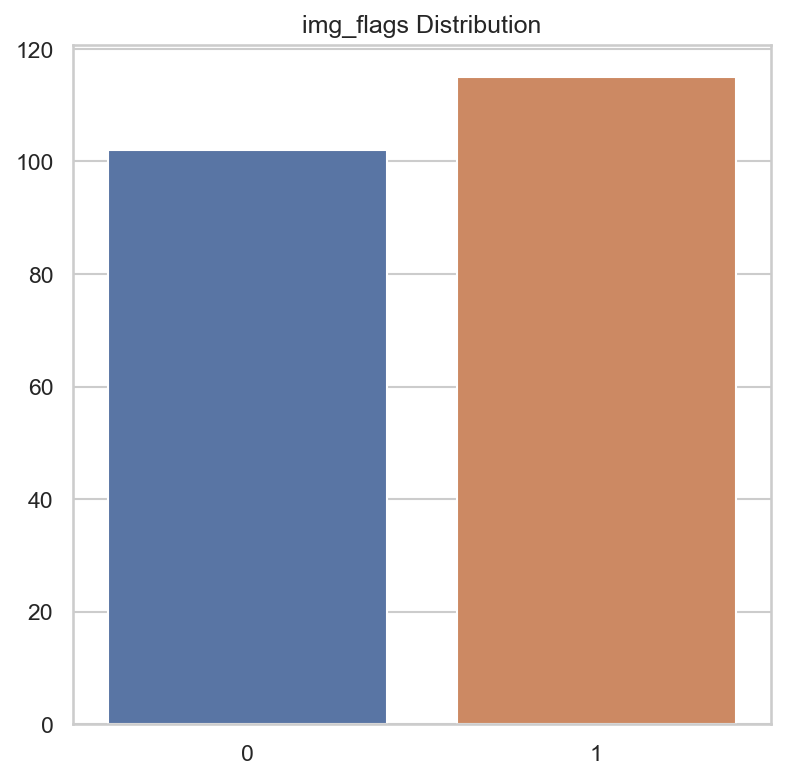

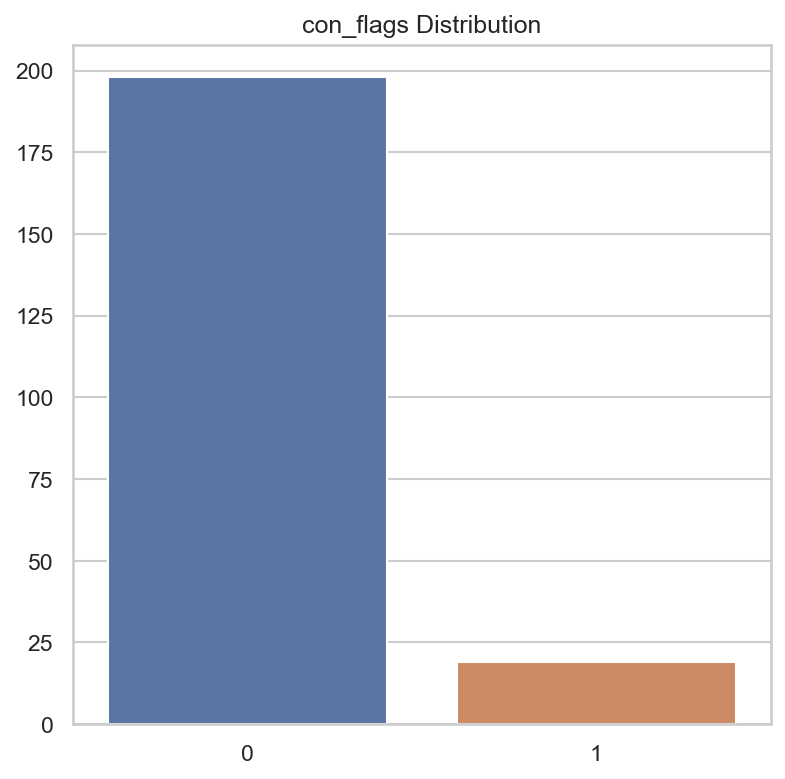

In [13]:
for col in feature_columns_cat:

    # Create figure variables
    fldist_fig, fldist_axes = plt.subplots()
    sns.countplot(data=df, x=col, ax=fldist_axes)

    # Set text
    fldist_axes.set_title(col + ' Distribution')
    fldist_axes.set_ylabel('')
    fldist_axes.set_xlabel('')
    fldist_fig.set_figheight(6)
    fldist_fig.set_figwidth(6)

    # Save figure
    #fldist_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['EDA'], '{}_distributionbylabel.svg'.format(col)))

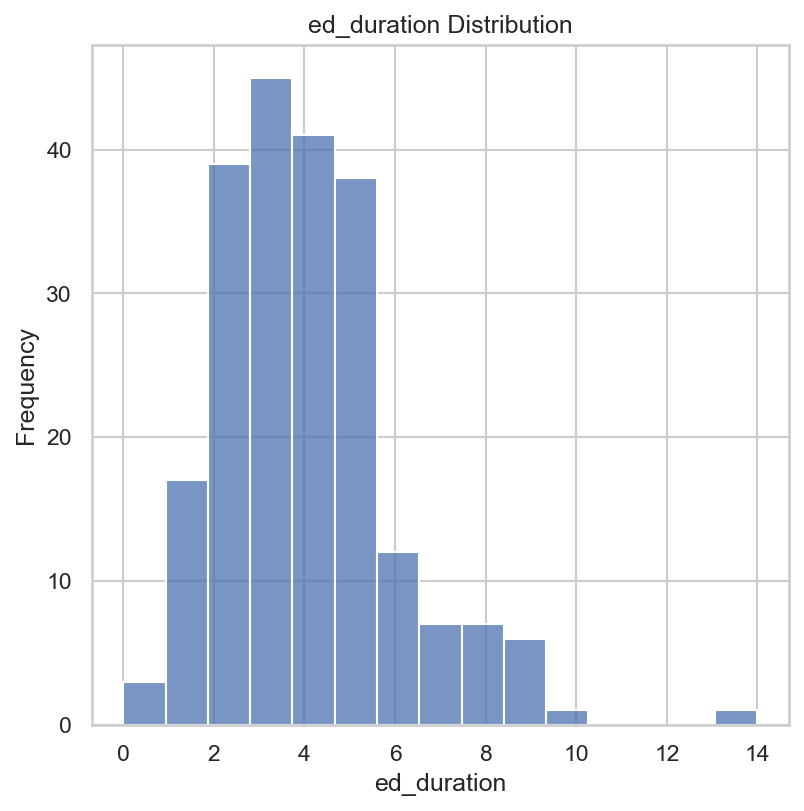

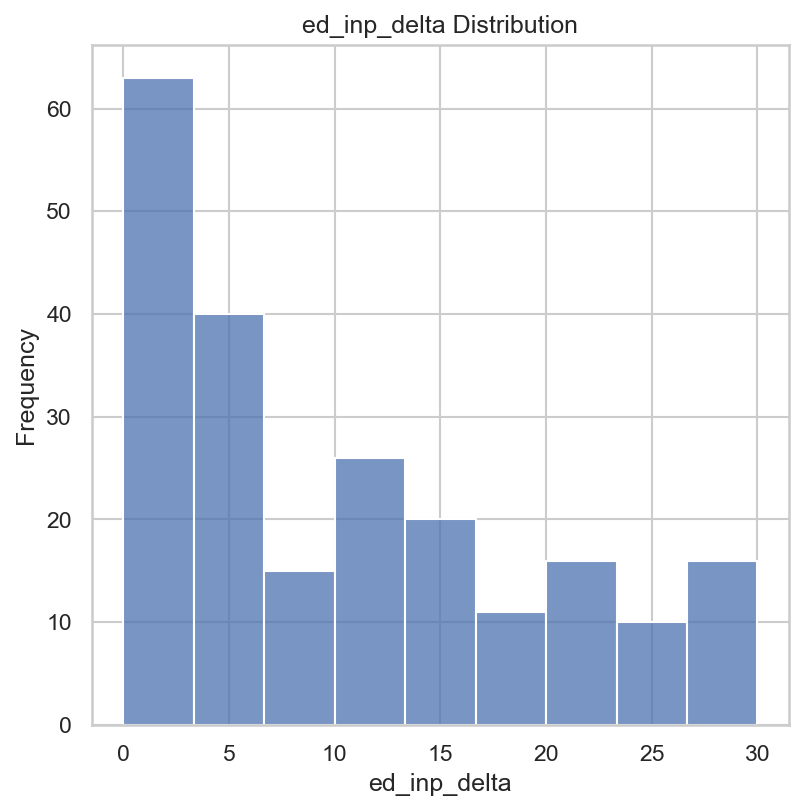

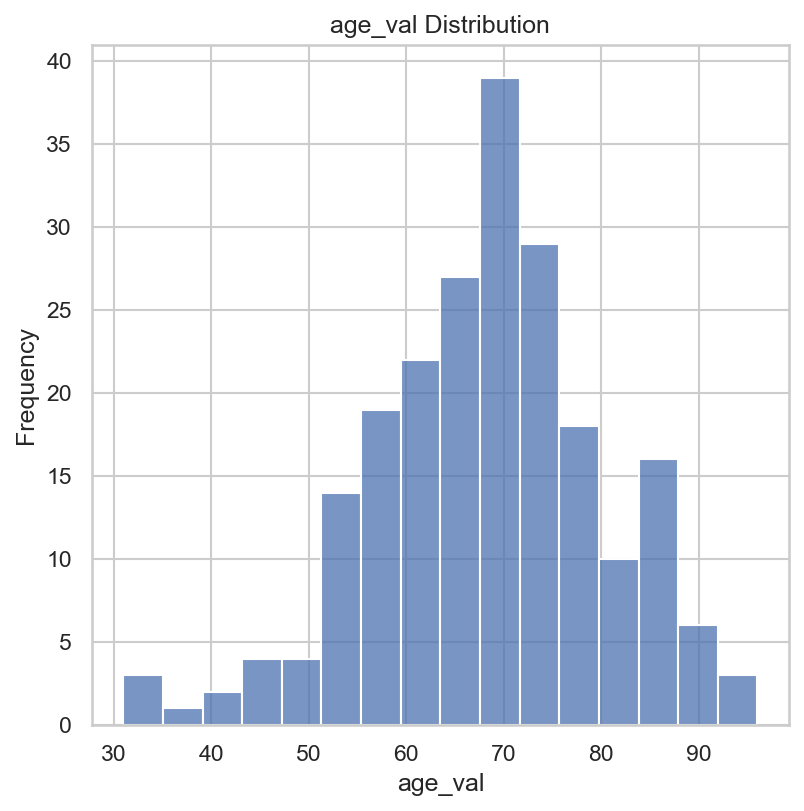

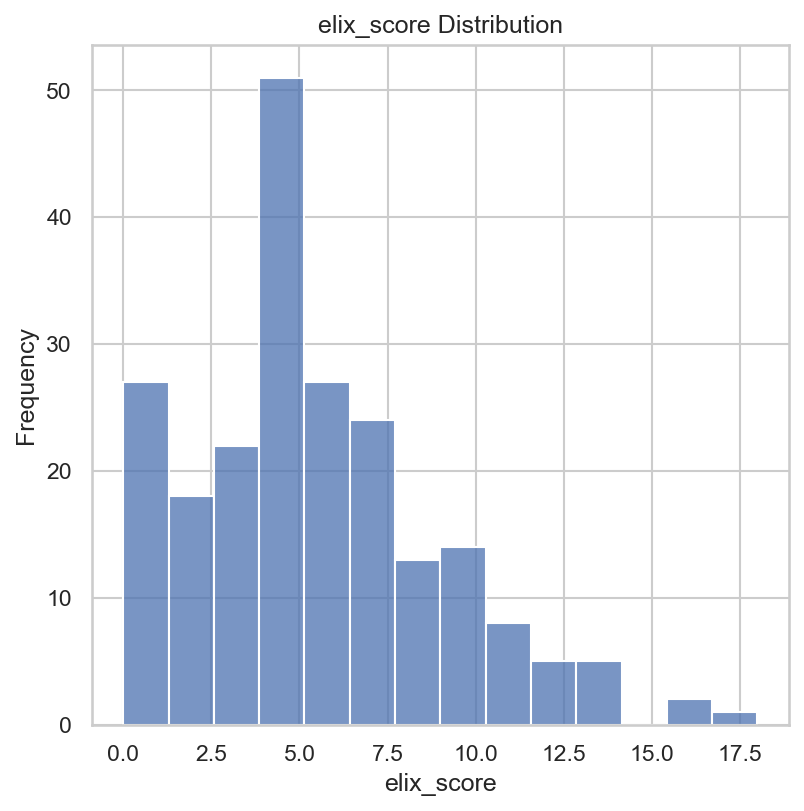

In [15]:
for col in feature_columns_cont:

    # Create figure variables
    fldist_fig, fldist_axes = plt.subplots()
    sns.histplot(data=df, x=col, ax=fldist_axes)

    # Set text
    fldist_axes.set_title(col + ' Distribution')
    fldist_axes.set_ylabel('Frequency')
    fldist_axes.set_xlabel(col)
    fldist_fig.set_figheight(6)
    fldist_fig.set_figwidth(6)

    # Save figure
    #fldist_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['EDA'], '{}_distributionbylabel.svg'.format(col)))

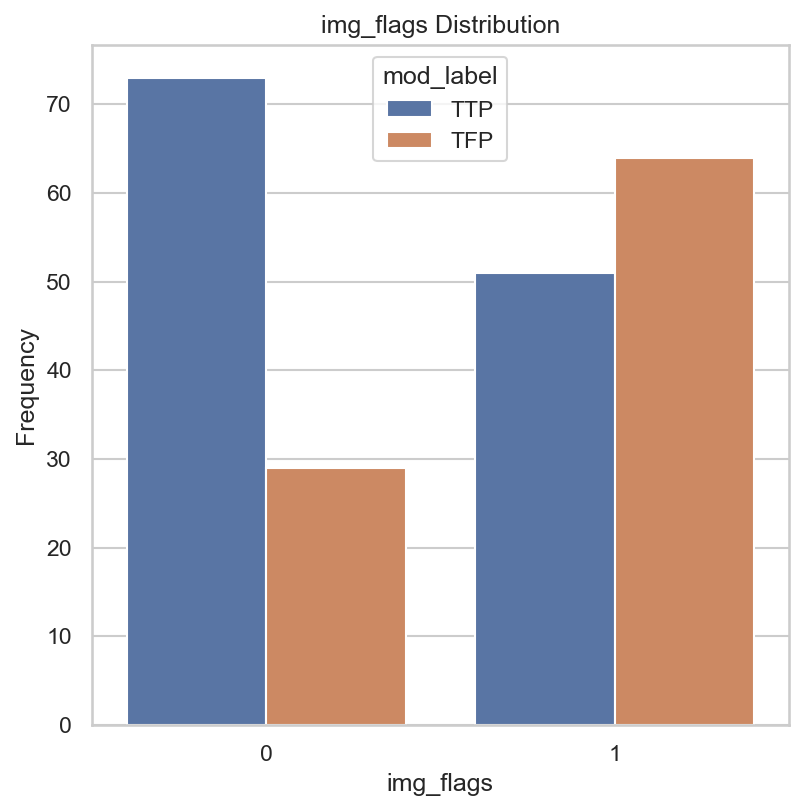

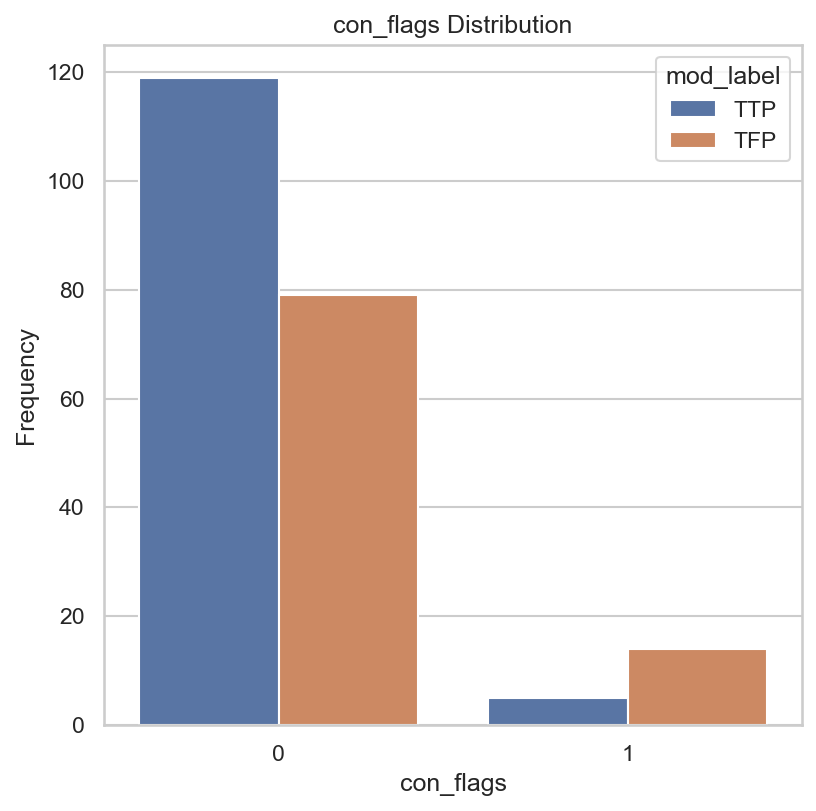

In [16]:
for col in feature_columns_cat:

    # Create figure variables
    fldist_fig, fldist_axes = plt.subplots()
    sns.countplot(data=df, x=col, hue=label_column, ax=fldist_axes)

    # Set text
    fldist_axes.set_title(col + ' Distribution')
    fldist_axes.set_ylabel('Frequency')
    fldist_axes.set_xlabel(col)
    fldist_fig.set_figheight(6)
    fldist_fig.set_figwidth(6)

    # Save figure
    #fldist_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['EDA'], '{}_distributionbylabel.svg'.format(col)))

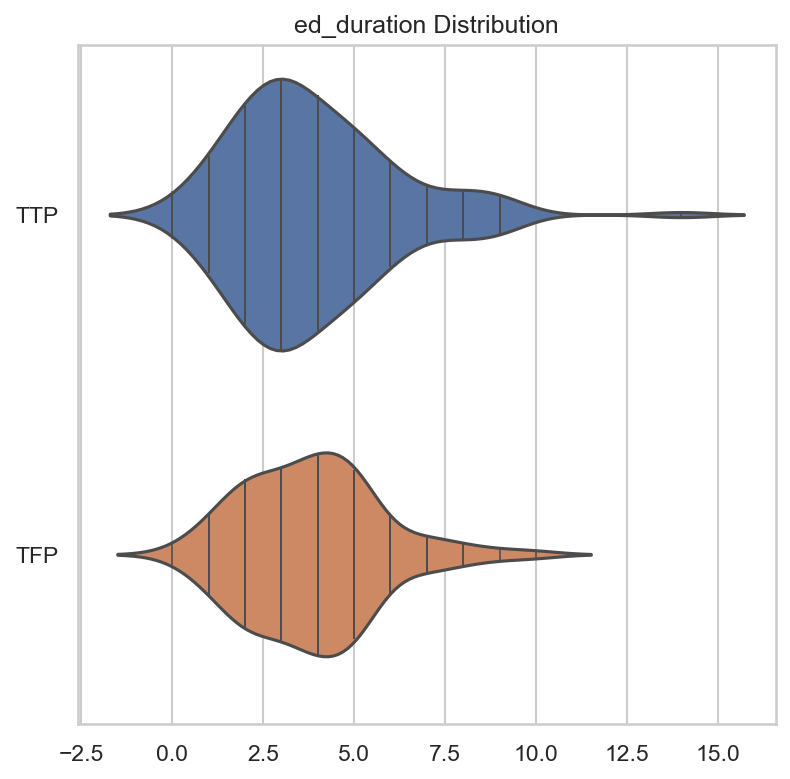

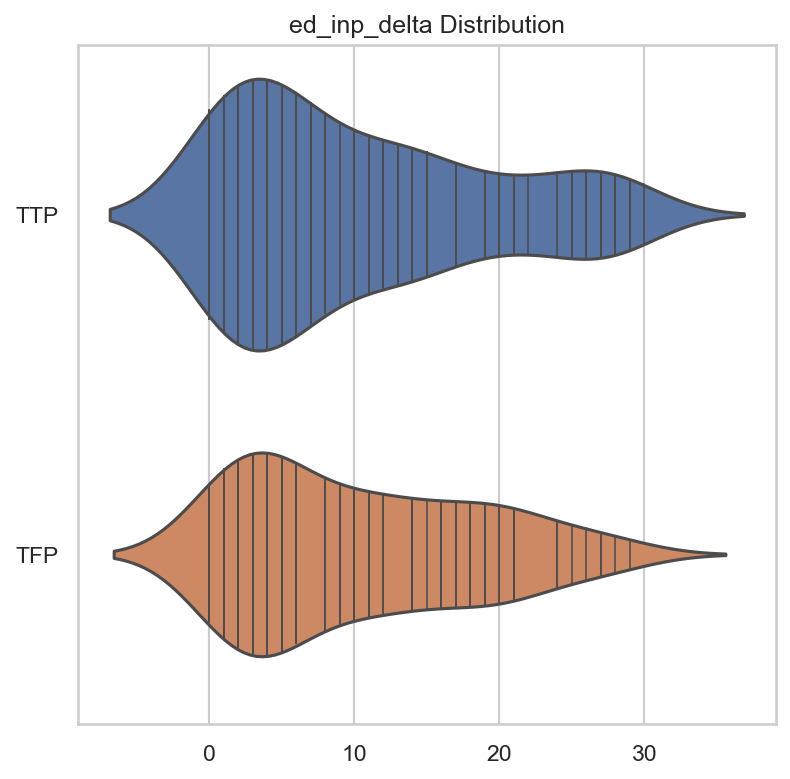

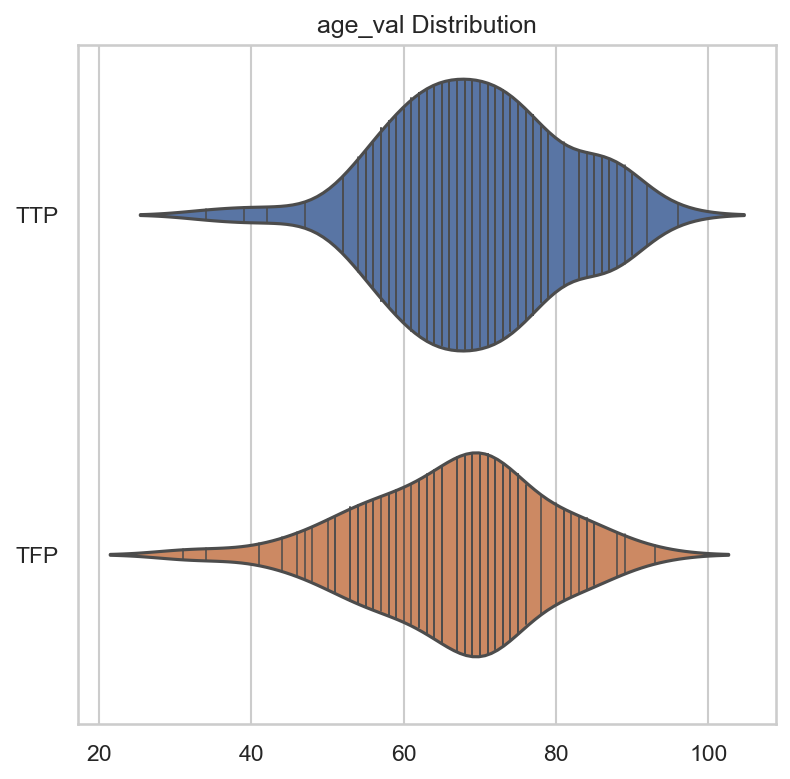

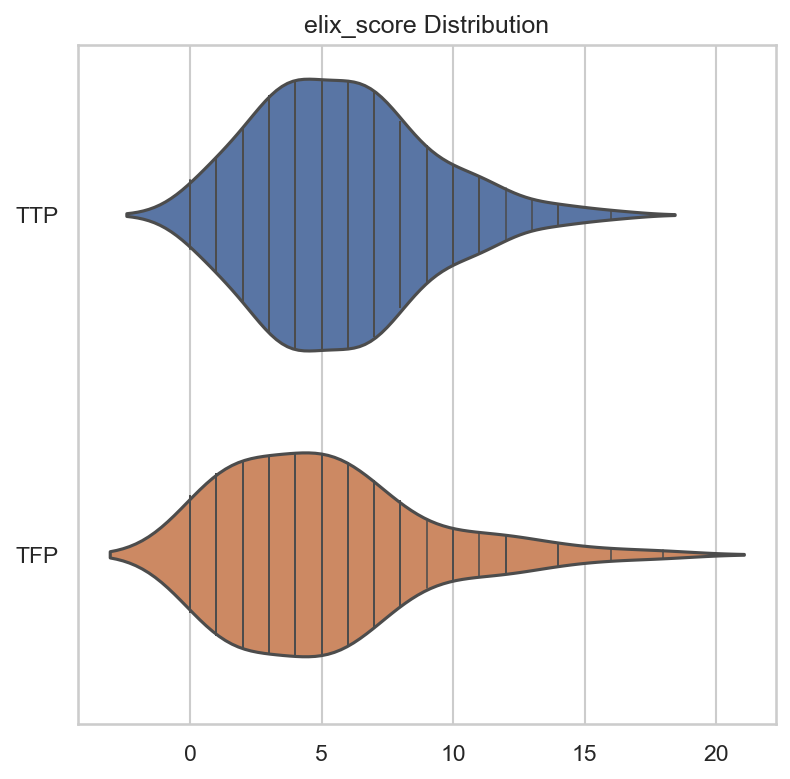

In [17]:
for col in feature_columns_cont:

    # Create figure variables
    fldist_fig, fldist_axes = plt.subplots()
    sns.violinplot(data=df, x=col, y=label_column, scale='count', inner='stick', ax=fldist_axes)

    # Set text
    fldist_axes.set_title(col + ' Distribution')
    fldist_axes.set_ylabel('')
    fldist_axes.set_xlabel('')
    fldist_fig.set_figheight(6)
    fldist_fig.set_figwidth(6)

    # Save figure
    #fldist_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['EDA'], '{}_distributionbylabel.svg'.format(col)))



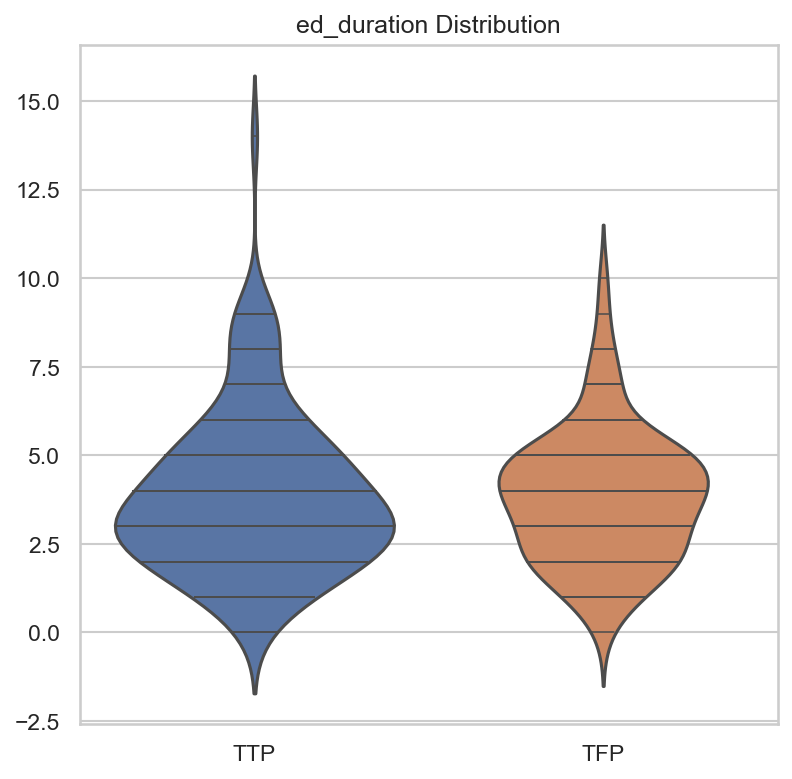

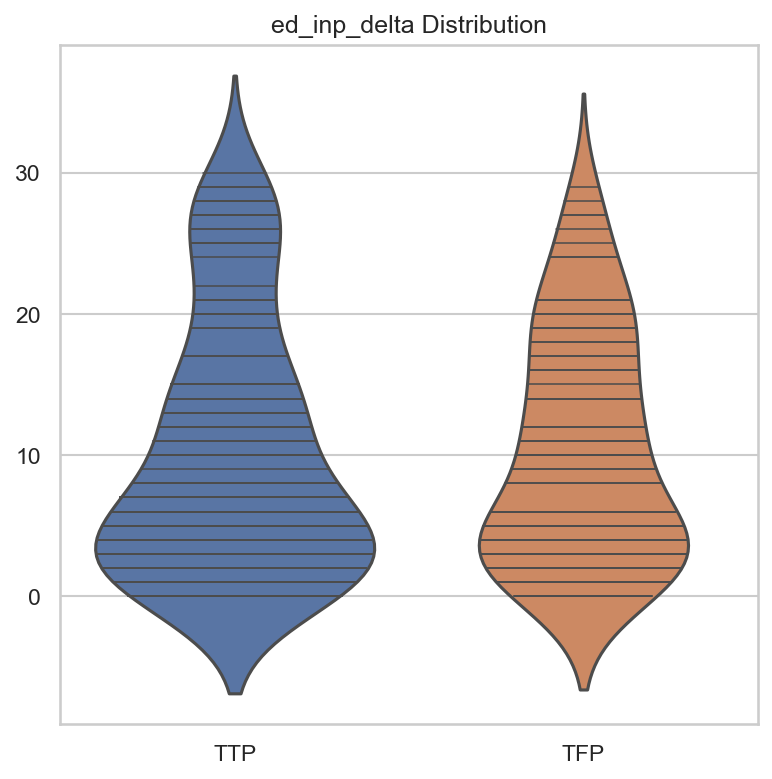

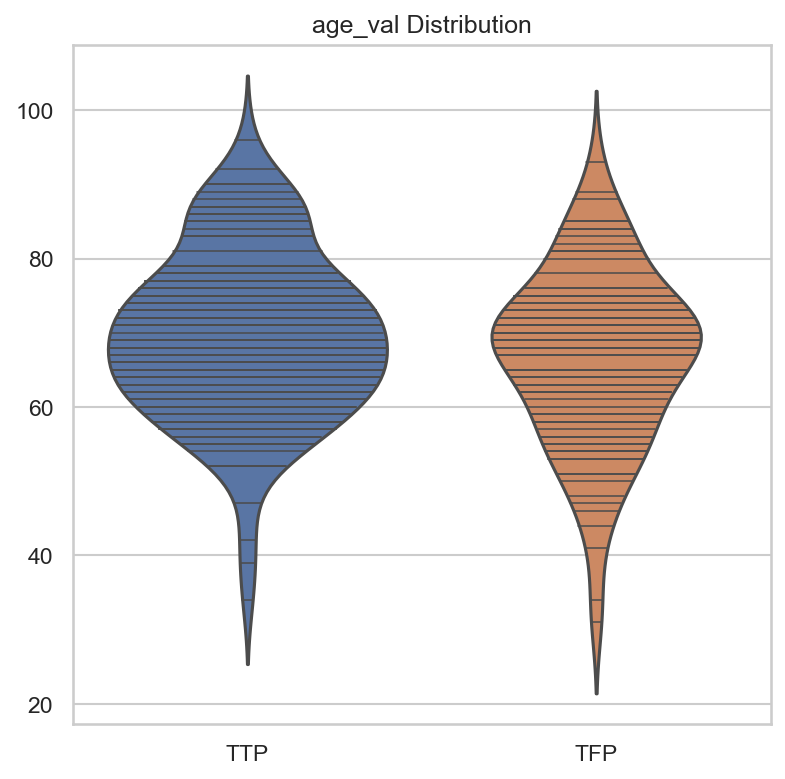

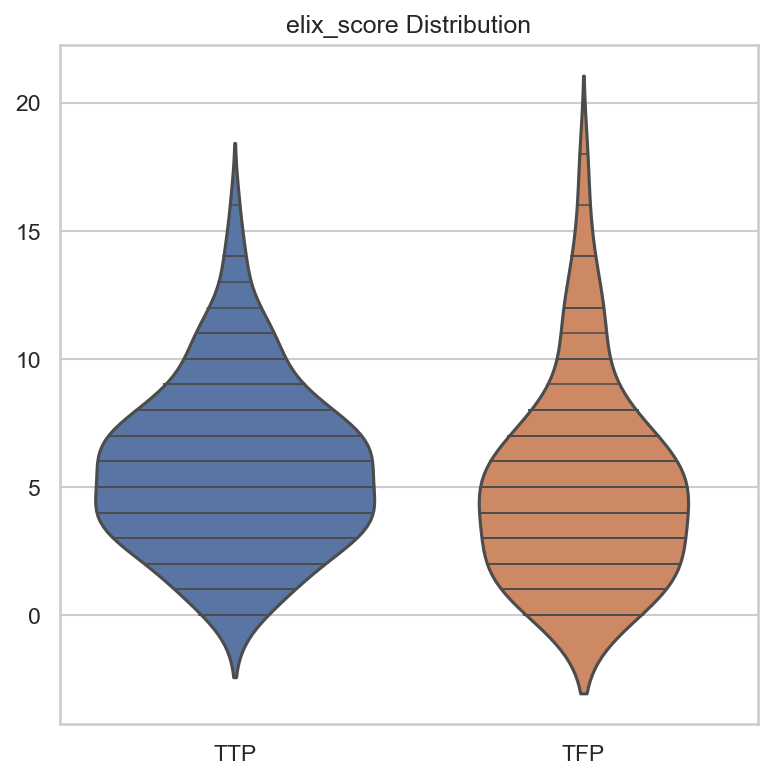

In [27]:
for col in feature_columns_cont:

    # Create figure variables
    fldist_fig, fldist_axes = plt.subplots()
    sns.violinplot(data=df, x=label_column, y=col, scale='count', inner='stick', ax=fldist_axes)

    # Set text
    fldist_axes.set_title(col + ' Distribution')
    fldist_axes.set_ylabel('')
    fldist_axes.set_xlabel('')
    fldist_fig.set_figheight(6)
    fldist_fig.set_figwidth(6)

    # Save figure
    #fldist_fig.savefig(os.path.join(OUTPUT_DIRECTORY_FILEPATHS['EDA'], '{}_distributionbylabel.svg'.format(col)))

In [26]:
# do a ttest on the categorical columns

from scipy.stats import ttest_ind, mannwhitneyu

for col in feature_columns_cat:
    tstat, pval = ttest_ind(df[df.mod_label=='TFP'][col],df[df.mod_label=='TTP'][col] )
    if pval < 0.05:
        print(col,pval)

# do a MannWhitney test on continuous columns

for col in feature_columns_cont:
    tstat, pval = mannwhitneyu(df[df.mod_label=='TFP'][col],df[df.mod_label=='TTP'][col] )
    if pval < 0.05:
        print(col,pval)

img_flags 4.1342553073177336e-05
con_flags 0.004330418033418919
elix_score 0.016662037986014025


(217, 2)


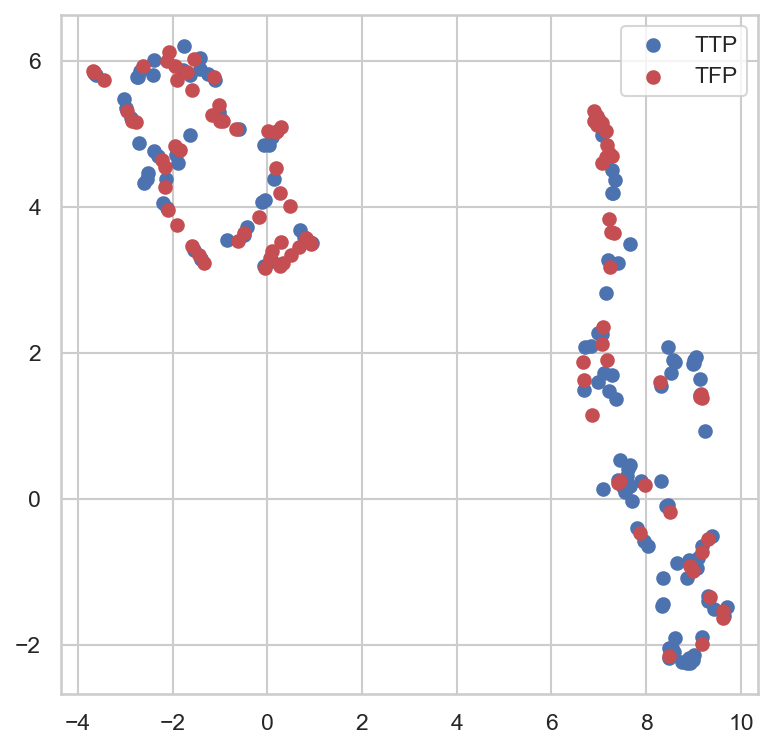

In [63]:
# do a UMAP plot of the data

X = df[feature_columns_cat+feature_columns_cont].values
y = df[label_column]

# scale the data
scaler = StandardScaler()
sX = scaler.fit_transform(X)

reducer = umap.UMAP(n_neighbors=10,min_dist=0.0,metric='correlation',random_state=4)
embedding = reducer.fit_transform(sX)
print(embedding.shape)

plt.scatter(embedding[y=='TTP',0],embedding[y=='TTP',1],c='b',label='TTP')
plt.scatter(embedding[y=='TFP',0],embedding[y=='TFP',1],c='r',label='TFP')
plt.legend(loc='upper right')

In [64]:
# do a kmeans cluster
from sklearn.cluster import KMeans

clust = KMeans(n_clusters=2)
clust.fit(embedding)

for i in range(2):
    print('Cluster :',i)
    print(y[clust.labels_==i].value_counts())

Cluster : 0
TFP    51
TTP    49
Name: mod_label, dtype: int64
Cluster : 1
TTP    75
TFP    42
Name: mod_label, dtype: int64


In [ ]:
display(df[clust.labels_==0].describe())
display(df[clust.labels_==1].describe())

# Get Li's fresh data on RF_SPADE trigger

In [265]:
import futil

tables = futil.getA00_Tables()
tables.keys()

dict_keys(['Rad', 'Note', 'ICD', 'Vital', 'RxOutpat', 'Demorgraphics', 'DispensedDrug', 'HealthFactor', 'NonVAMed', 'AllMed', 'cohort', 'Consult', 'Lab'])

# Plan A
- get cohort, ICDs, RxOutpat, consult,  demog, notes, rad for initial analysis

In [266]:
cohort, ICDs, RxOutpat, consult, demog, notes, rad = futil.get_relevant_tables(tables)

array([[<AxesSubplot:title={'center':'visit_count'}>]], dtype=object)

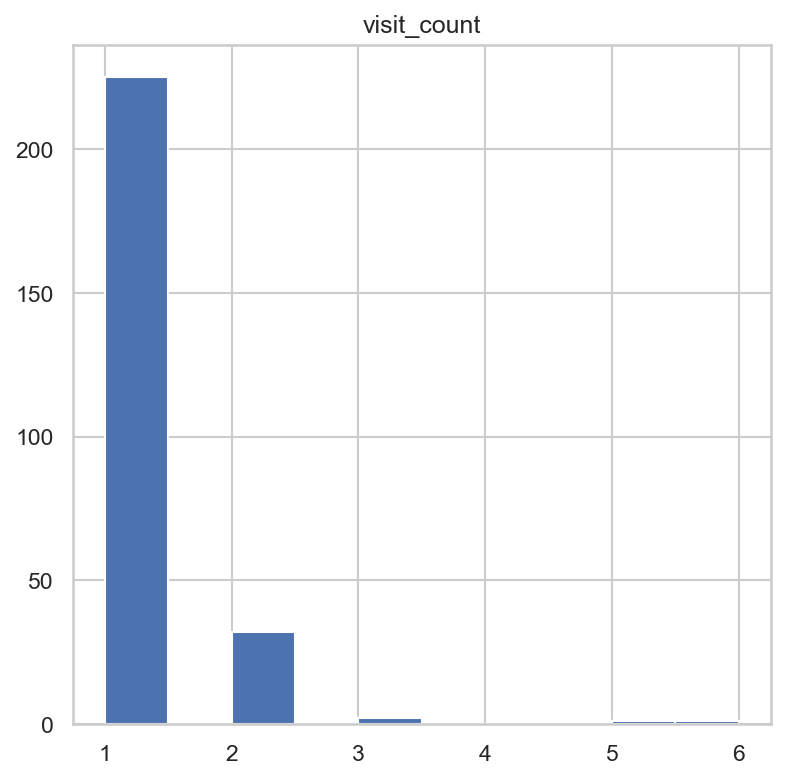

In [4]:
futil.indexERVisitCount(cohort).hist()

In [272]:
all_patient_df = pd.DataFrame(set(cohort.patientSSN),columns=['PatientSSN'])

# Preparing the drugs data for analysis
- Read the drug categories
- get VA Class to super category mapping for a prescribed drug
- limit all RxOutpatient drugs to the VA classes
- map RxOutpatient drugs to their super categories

In [276]:
# read the drug classes prepared by andy
drug_classes = pd.read_csv('../ml-detect-diagnostic-safety-git-repo/short-list-drug-classes.csv')
super_drug_categories = drug_classes[['VA Class','super category']]

# limit analysis to meds in the desired classes; associate supercategory with each class
RxOutpat_lim = futil.filterDFByCodeSet(RxOutpat, 'DrugClassCode', drug_classes['VA Class'])
RxOutpat_lim_supercat = pd.merge(RxOutpat_lim,super_drug_categories,left_on='DrugClassCode',right_on='VA Class')

# get dates of index visit for each patient
first_ed_visit_dict = futil.extractFirstVisitIndexDatetime(cohort)

# filter records to only those in a 180 day window prior to index visit
Rx_filtered = futil.filterDFByTimes(RxOutpat_lim_supercat, 'PatientSSN', 'DispensedDate', first_ed_visit_dict).copy()

# adjust quantity appropriately
Rx_relevant = futil.makeRxOutpatTimeWindowVec(Rx_filtered, first_ed_visit_dict,180)

# group by patient and supercategory and sum up usage of medicines
tmp = Rx_relevant.groupby(['PatientSSN','super category'])['Mod_quantity'].agg('sum').reset_index()

# pivot table and make a feature vector for each patient
drug_feat_df = pd.pivot_table(tmp,values='Mod_quantity',index='PatientSSN',columns='super category',aggfunc=np.sum)


drug_feat_df = pd.merge(drug_feat_df,all_patient_df,left_index=True,right_on='PatientSSN',how='right')
drug_feat_df.fillna(0,inplace=True)

In [ ]:
drug_feat_df

# ICD code feature generation

In [186]:
# restrict attention to ICD records prior to index visit
ICDs_timefilt = ICDs[ICDs.apply(lambda x: x.DiagDateTime <= first_ed_visit_dict[x.PatientSSN],axis=1 )].copy()

# separate ICD records into ICD9 codes and ICD10 code
cond9 = ICDs_timefilt.ICD.apply(futil.isfloat)
ICD9s_timefilt = ICDs_timefilt[cond9].copy()
cond10 = ICDs_timefilt.ICD.apply(futil.isnotfloat)
ICD10s_timefilt = ICDs_timefilt[cond10].copy()

In [183]:
# read the ICD9 and ICD10 stroke risk factors
ICD9_FILEPATH = "P:\ORD_Singh_201911038D\Maxxxx\ICD\p_Refined_SPADE_RiskFactors_riskfactor_ICD9codes.csv"
ICD10_FILEPATH = "P:\ORD_Singh_201911038D\Maxxxx\ICD\p_Refined_SPADE_RiskFactors_riskfactor_ICD10codes.csv"

icd9_stroke_RF = pd.read_csv(ICD9_FILEPATH)[['ICD-9-CM CODE','Description']]
icd9_stroke_RF.columns=['ICD','Description']
icd10_stroke_RF = pd.read_csv(ICD10_FILEPATH)[['ICD-10-CM Code','Risk factors description']]
icd10_stroke_RF.columns=['ICD','Description']

In [189]:
# merge the ICD records with the stroke risk factor codes
ICD9s_timefilt.ICD = ICD9s_timefilt.ICD.astype(float)
ICD9s_codes = pd.merge(ICD9s_timefilt,icd9_stroke_RF)
ICD10s_codes = pd.merge(ICD10s_timefilt,icd10_stroke_RF)

In [278]:
# group by patient and description and count up ICD9s
tmp9 = ICD9s_codes.groupby(['PatientSSN','Description'])['ICD'].agg('count').reset_index()

# pivot table and make a feature vector for each patient
icd9_feat_df = pd.pivot_table(tmp9,values='ICD',index='PatientSSN',columns='Description')
icd9_feat_df = pd.merge(icd9_feat_df,all_patient_df,left_on='PatientSSN',right_on='PatientSSN',how='right')
icd9_feat_df.fillna(0,inplace=True)

# group by patient and description and count up ICD10s
tmp10 = ICD10s_codes.groupby(['PatientSSN','Description'])['ICD'].agg('count').reset_index()

# pivot table and make a feature vector for each patient
icd10_feat_df = pd.pivot_table(tmp10,values='ICD',index='PatientSSN',columns='Description')
icd10_feat_df = pd.merge(icd10_feat_df,all_patient_df,left_on='PatientSSN',right_on='PatientSSN',how='right')
icd10_feat_df.fillna(0,inplace=True)

In [284]:
print(icd9_feat_df.columns)
print(icd10_feat_df.columns)
# normalize column names
icd9_feat_df.columns = ['PatientSSN','AFib/Hx of atrial fibrillation', 'Coronary artery disease (CAD)',
       'Diabetes', 'Hx of cerebral aneurysm', 'Hx of stroke/TIA',
       'Hyperlipidemia', 'Hypertension',
       'Occlusion/Stenosis of cerebral or precerebral artery', 'Smoking']
icd10_feat_df.columns = ['PatientSSN','AFib/Hx of atrial fibrillation', 'Coronary artery disease (CAD)', 'Diabetes',
       'Hx of cerebral aneurysm', 'Hx of stroke/TIA', 'Hyperlipidemia', 'Hypertension',
       'Occlusion/Stenosis of cerebral or precerebral artery', 'Smoking']

Index(['PatientSSN', ' Hx of atrial fibrillation',
       'Coronary artery disease (CAD)', 'Diabetes', 'Hx of cerebral aneurysm',
       'Hx of stroke/TIA', 'Hyperlipdemia', 'Hypertension',
       'Occlusion/Stenosis of cerebral or precerebral artery', 'Smoking'],
      dtype='object')
Index(['PatientSSN', 'Atrial fibrillation', 'Coronary artery disease (CAD)',
       'Diabetes', 'Hx aneurysm', 'Hx of stroke or TIA', 'Hyperlipidemia',
       'Hypertension', 'Occlusion/Stenosis of cerebral or precerebral artery',
       'Smoking'],
      dtype='object')


In [353]:
# sum the ICD counts across both ICD9 and ICD10 tables
icd_feat_df = icd9_feat_df.copy()
for col in list(icd9_feat_df.columns[1:]):
    icd_feat_df[col] += icd10_feat_df[col]
icd_feat_df.shape

(261, 10)

# Get demographics features

In [297]:
# convert date fields to pandas format
demog.DOB = pd.to_datetime(demog.DOB)
demog.IndexDateTime = pd.to_datetime(demog.IndexDateTime)
demog['age_at_index_visit'] = np.round((demog['IndexDateTime'] - demog['DOB']).dt.days/365.,2)

# pull out relevant demographic fields
demo_df = demog[['patientSSN','DOB','age_at_index_visit','Gender','Ethnicity','Race']]

# if multiple records pick the first index visit
demo_df = demo_df.sort_values(by=['patientSSN','age_at_index_visit'],ascending=[True,True])

demo_df = demo_df.drop_duplicates(subset=['patientSSN'],keep='first')

# Analysis of consults at index ED visit
- need to merge consult and cohort (with first index visit)
- get all consults issues after EDStart and before EdEnd
- filter out neurology consult

In [329]:
fv_cohort = cohort.sort_values(by=['patientSSN','EDStartDateTime'],ascending=[True,True])
fv_cohort = fv_cohort.drop_duplicates(subset=['patientSSN'],keep='first')

merged_consult = pd.merge(consult,fv_cohort,left_on='PatientSSN',right_on='patientSSN')
# filter consults to first ED visit
mconsult_timefilt = merged_consult[merged_consult.apply(lambda x: (x.RequestDateTime >= x.EDStartDateTime) and (x.RequestDateTime <= x.EDEndDateTime),axis=1 )].copy()

# filter out the neuro consults
neuro_consults_at_index = mconsult_timefilt[mconsult_timefilt.ConStopCodeName.str.contains('NEURO',na=False)]
# aggregate the numbers on a perpatient basis
tmp_neuro = neuro_consults_at_index.groupby('PatientSSN')['ConStopCode'].agg('count').reset_index()
num_neuro_df = pd.merge(all_patient_df,tmp_neuro,left_on='PatientSSN',right_on='PatientSSN',how='left')[['PatientSSN','ConStopCode']]
num_neuro_df.fillna(0,inplace=True)
num_neuro_df.rename(columns={'ConStopCode':'num_neuro_at_ed_visit'},inplace=True)

# Radiology table

- need to merge rad and cohort (with first index visit)
- get all rad requests after EDStart and before EdEnd
- filter out MRI and CT rad records


In [324]:
merged_rad = pd.merge(rad,fv_cohort,left_on='PatientSSN',right_on='patientSSN')
# filter rad to first ED visit
mrad_timefilt = merged_rad[merged_rad.apply(lambda x: (x.ExamDateTime >= x.EDStartDateTime) and (x.ExamDateTime <= x.EDEndDateTime),axis=1 )].copy()


# filter radiology records to MRI and CT scans
relevant_ct_scans=['CT HEAD/BRAIN W/O DYE','CT HEAD/BRAIN W/O & W/DYE','CT HEAD/BRAIN W/DYE']
relevant_mri_scans = ['MRI BRAIN STEM W/O DYE','MRI BRAIN STEM W/O & W/DYE','MRI BRAIN STEM W/DYE']

# count up MRI scan for each patient around first ED visit
tmp_mri_scans = mrad_timefilt[mrad_timefilt.CPTName.isin(relevant_mri_scans)].groupby(['PatientSSN','CPTName'])['CPTCode'].agg('count').reset_index()
mri_scan_df = pd.pivot_table(tmp_mri_scans,values='CPTCode',index='PatientSSN',columns='CPTName')
mri_scan_df = pd.merge(mri_scan_df,all_patient_df,left_on='PatientSSN',right_on='PatientSSN',how='right')
mri_scan_df.fillna(0,inplace=True)

# count up CT scan for each patient around first ED visit
tmp_ct_scans = mrad_timefilt[mrad_timefilt.CPTName.isin(relevant_ct_scans)].groupby(['PatientSSN','CPTName'])['CPTCode'].agg('count').reset_index()
ct_scan_df = pd.pivot_table(tmp_ct_scans,values='CPTCode',index='PatientSSN',columns='CPTName')
ct_scan_df = pd.merge(ct_scan_df,all_patient_df,left_on='PatientSSN',right_on='PatientSSN',how='right')
ct_scan_df.fillna(0,inplace=True)

In [334]:
# combine MRI and CT into a single table with a count regardless of w or w/0 dye

ct_scan_df['ct_sum'] = ct_scan_df.apply(lambda x: np.sum(x[1:]),axis=1)
mri_scan_df['mri_sum'] = mri_scan_df.apply(lambda x: np.sum(x[1:]),axis=1)

# UMAP analysis with 
- demographics
- RxOutpat
- risk factors (ICD)
- MRI and CT scans (from radiology)
- neurology consults

In [371]:
# merge drug features and risk factors data frames

feat_vec_df = pd.merge(drug_feat_df,icd_feat_df,on='PatientSSN')

# merge MRI and CT scans dataframes
feat_vec_df = pd.merge(ct_scan_df[['PatientSSN','ct_sum']],feat_vec_df,on='PatientSSN')
feat_vec_df = pd.merge(mri_scan_df[['PatientSSN','mri_sum']],feat_vec_df,on='PatientSSN')

# merge neuro consult dataframe
feat_vec_df = pd.merge(num_neuro_df[['PatientSSN','num_neuro_at_ed_visit']],feat_vec_df,on='PatientSSN')

# merge with categorical encoded demo_df
demo_cat_df = pd.get_dummies(demo_df,columns=['Gender','Race','Ethnicity'])
demo_cols = set(demo_cat_df).difference(['DOB'])

feat_vec_df = pd.merge(feat_vec_df,demo_cat_df[demo_cols],left_on='PatientSSN',right_on='patientSSN')
feat_vec_df.drop(columns=['patientSSN'],inplace=True)

In [372]:
feat_vec_df.columns

Index(['PatientSSN', 'num_neuro_at_ed_visit', 'mri_sum', 'ct_sum',
       'anticoagulant', 'antihypertensive', 'antiplatelet', 'cholesterol',
       'diabetes', 'AFib/Hx of atrial fibrillation',
       'Coronary artery disease (CAD)', 'Diabetes', 'Hx of cerebral aneurysm',
       'Hx of stroke/TIA', 'Hyperlipidemia', 'Hypertension',
       'Occlusion/Stenosis of cerebral or precerebral artery', 'Smoking',
       'Race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'Gender_M',
       'Ethnicity_DECLINED TO ANSWER', 'age_at_index_visit',
       'Ethnicity_NOT HISPANIC OR LATINO', 'Race_UNKNOWN BY PATIENT',
       'Ethnicity_UNKNOWN BY PATIENT', 'Gender_F', 'Race_DECLINED TO ANSWER',
       'Race_WHITE', 'Race_ASIAN', 'Ethnicity_HISPANIC OR LATINO',
       'Race_BLACK OR AFRICAN AMERICAN'],
      dtype='object')

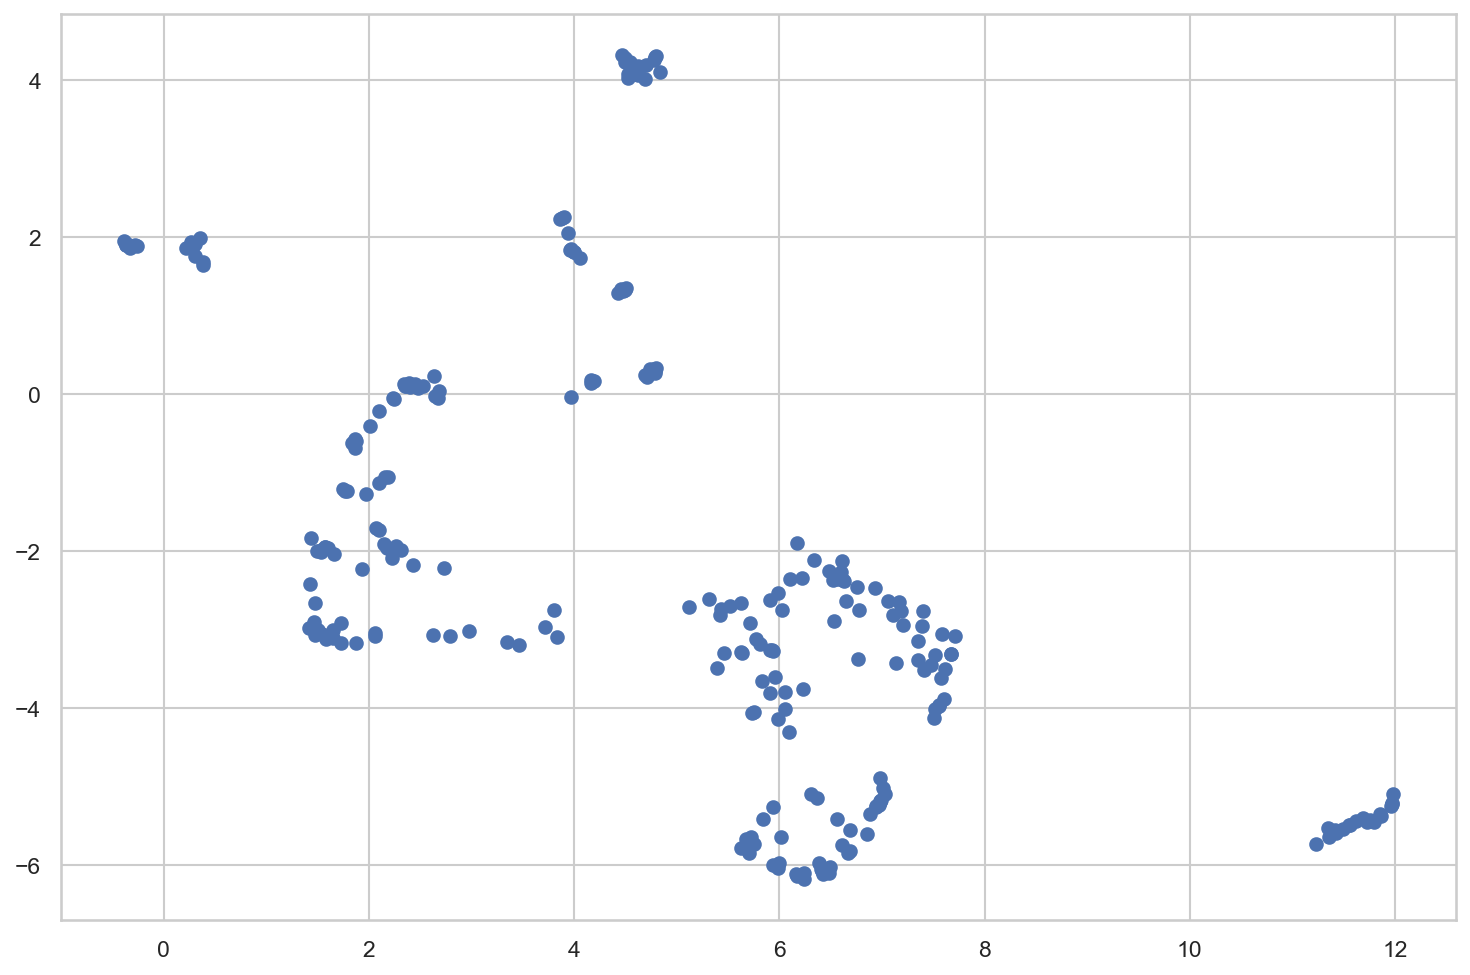

In [388]:
# standard scale all columns but the PatientSSN
X = preprocessing.StandardScaler().fit_transform(feat_vec_df.iloc[:,1:])
reducer = umap.UMAP(metric="correlation", min_dist=0,n_neighbors=15,random_state=3)
mapper = reducer.fit(X)

plt.figure(figsize=(12,8))
plt.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1], alpha=1.0)
plt.show()

Cluster 1
38

Cluster 2
70

Cluster 3
44

Cluster 4
40

Cluster 5
49

Cluster 6
20



KMeans(n_clusters=6)

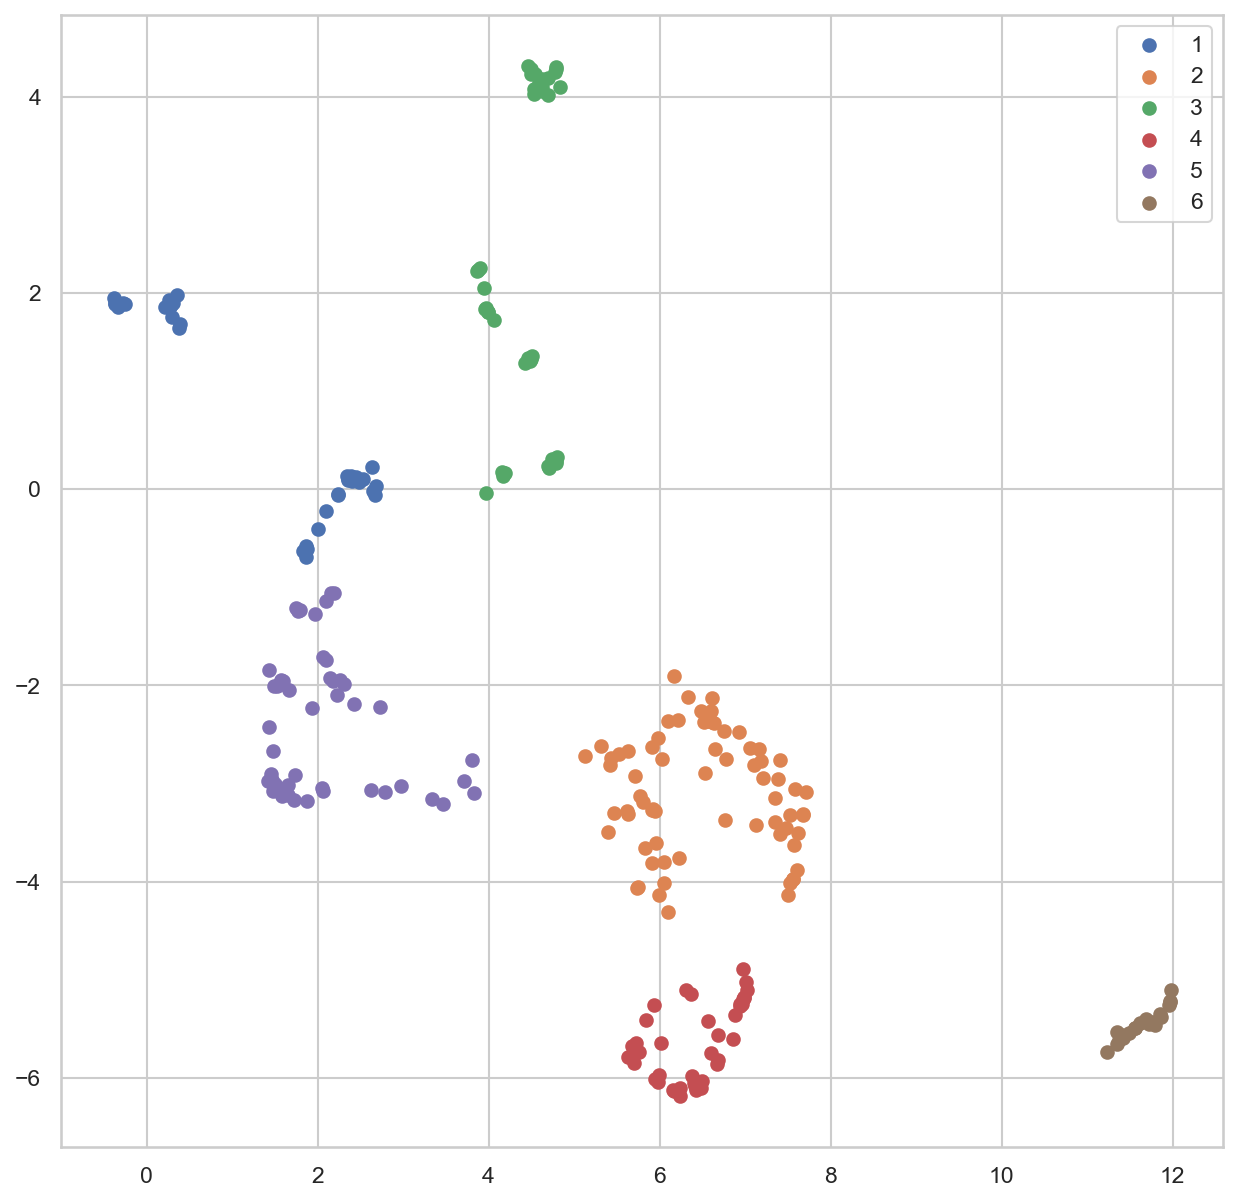

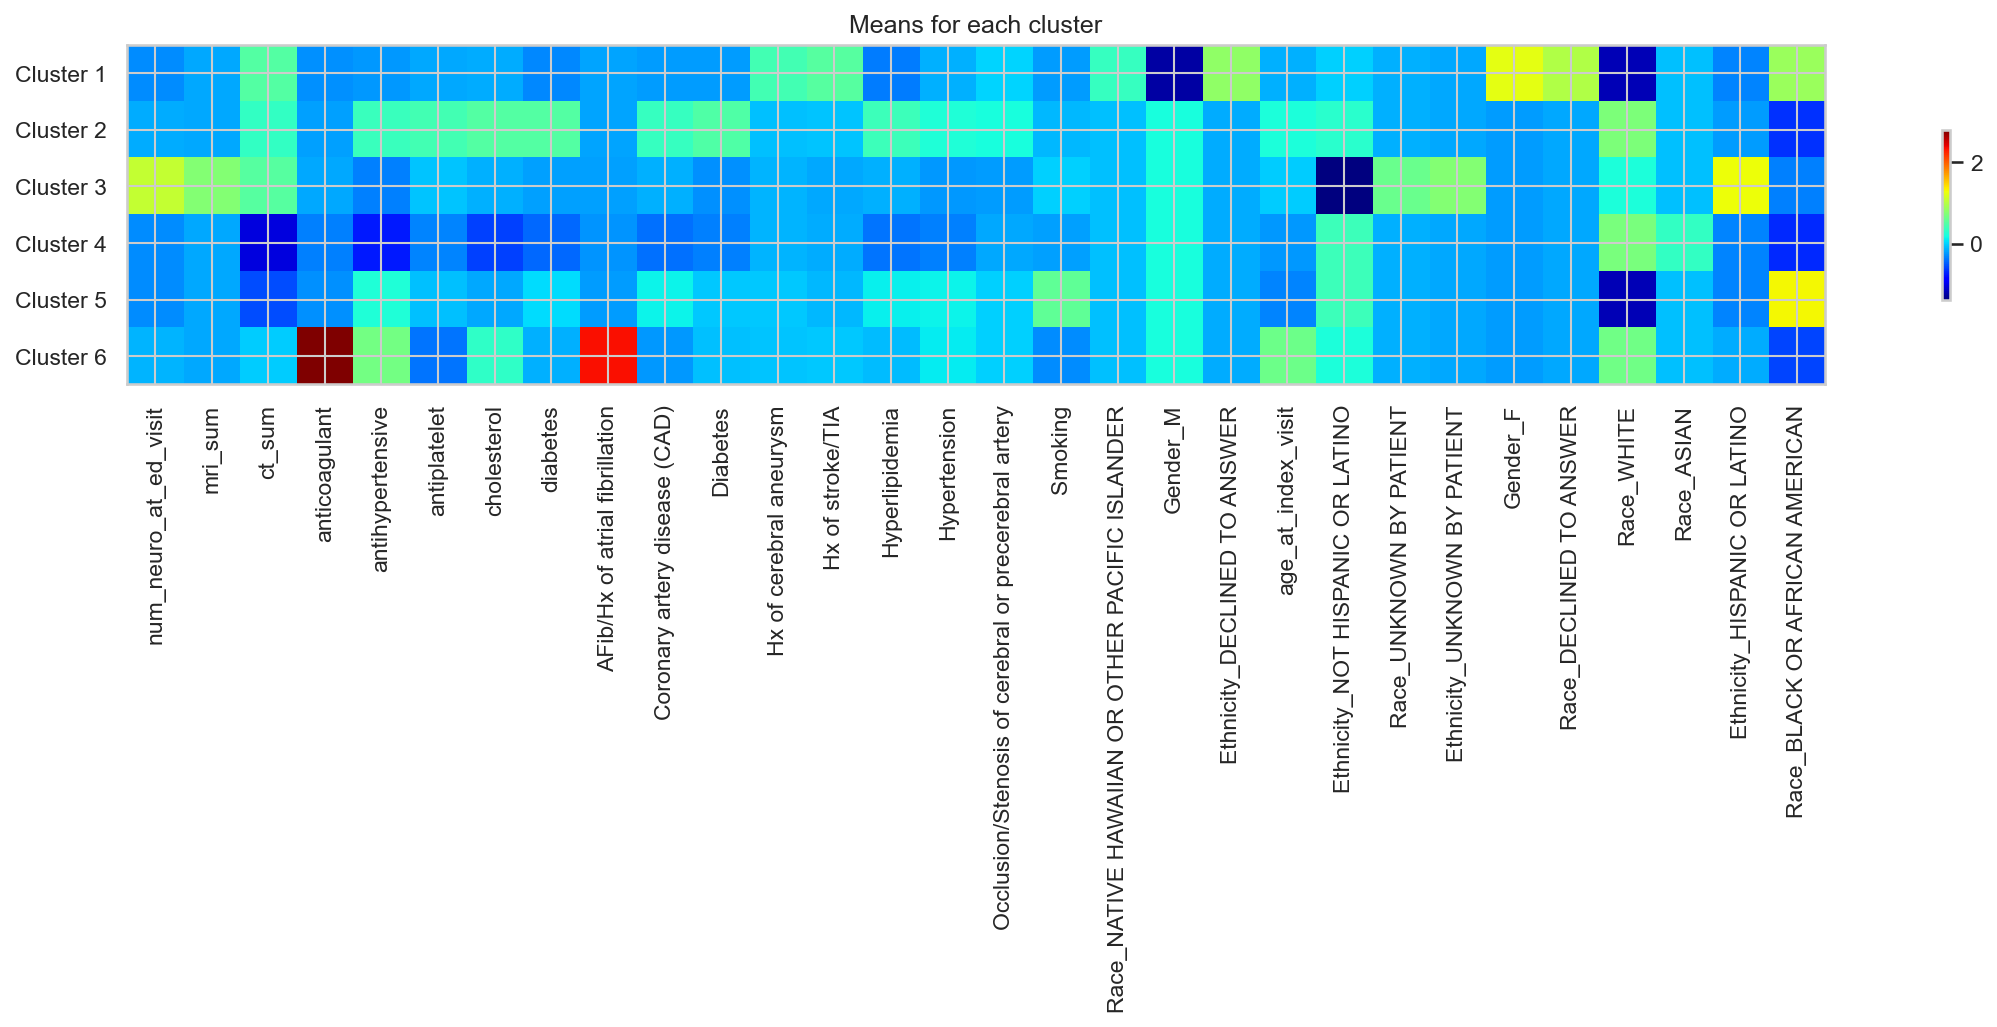

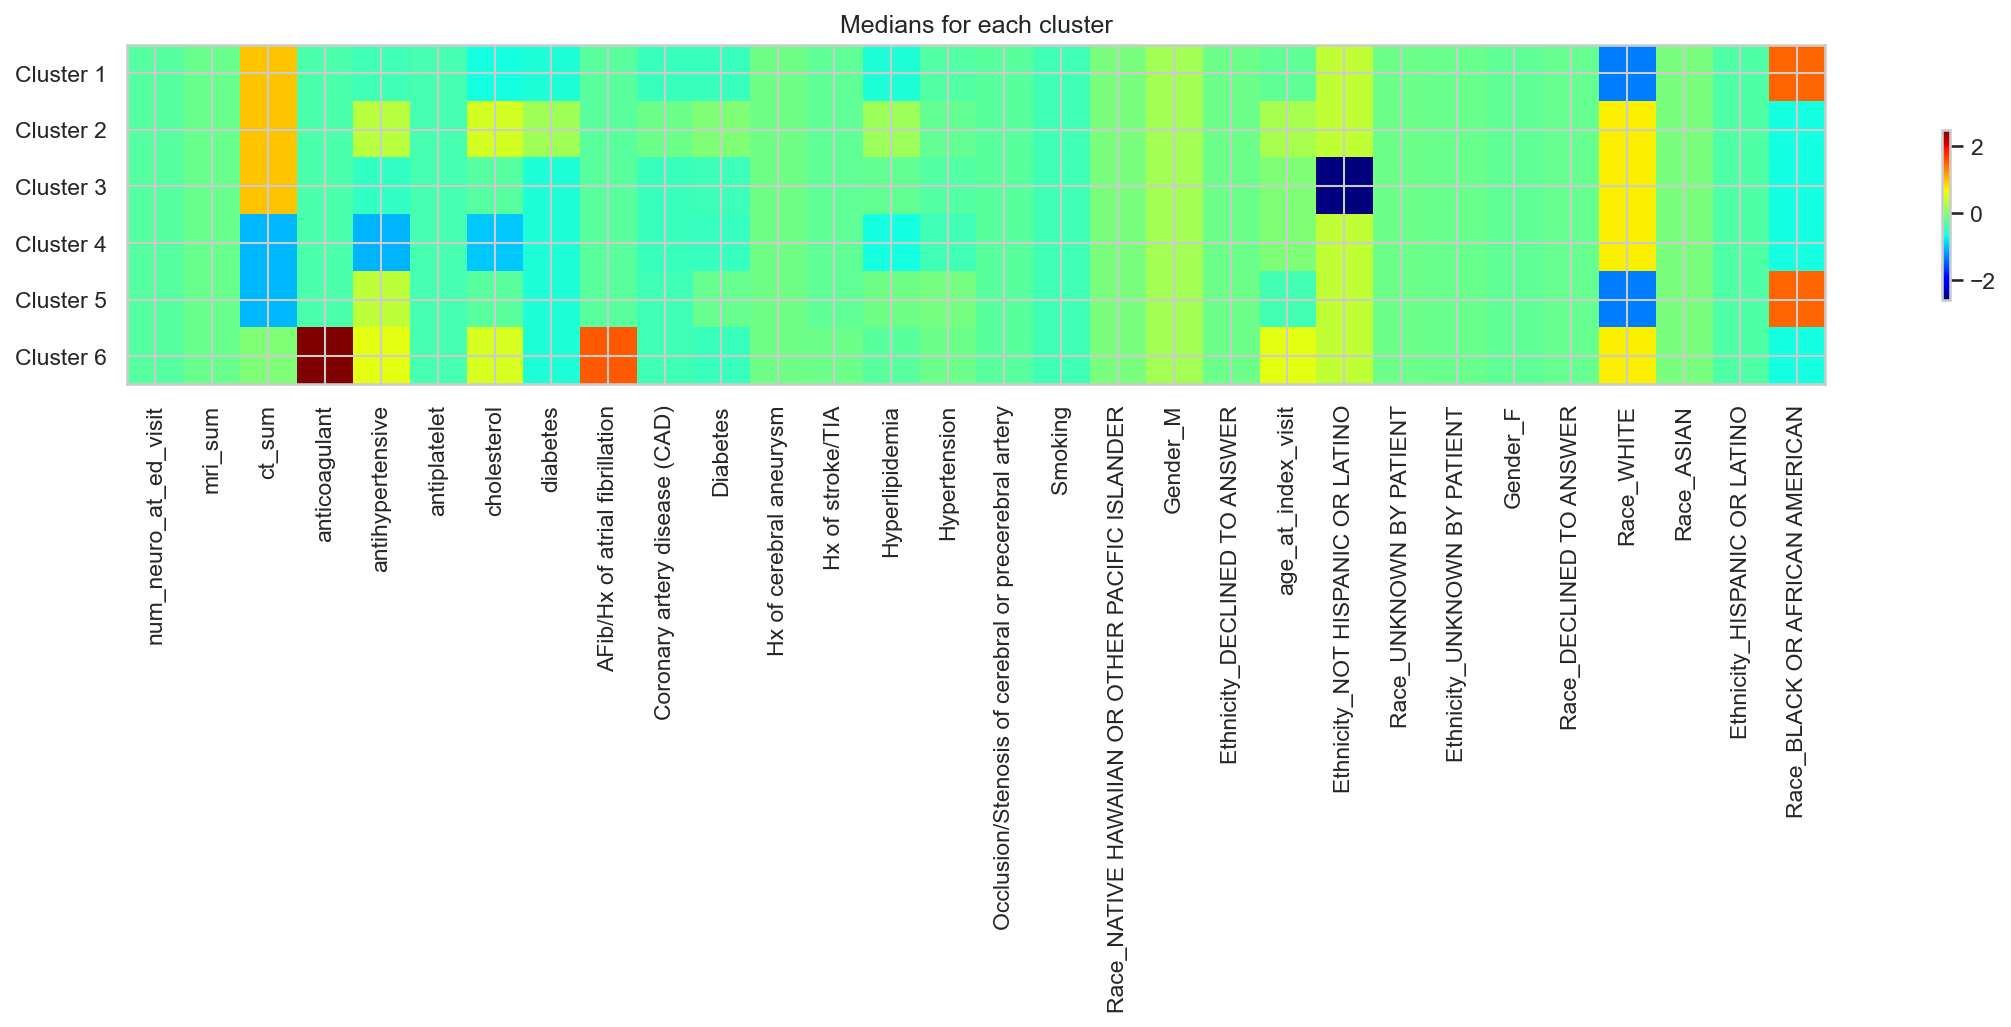

In [392]:
# run clustering on UMAP
futil.run_clustering_on_umap(mapper, 6,feat_vec_df, list(feat_vec_df.columns[1:]))

In [307]:
notes_timefilt = notes[notes.apply(lambda x: (x.EntryDateTime - first_ed_visit_dict[x.PatientSSN])<=pd.Timedelta(1,'D'),axis=1  )]


ADDENDUM                    27794
NURSING NOTE                 7122
NURSING INPATIENT NOTE       3232
ADMINISTRATIVE NOTE          2541
TELEPHONE ENCOUNTER NOTE     2086
PRIMARY CARE NOTE            2040
EMERGENCY DEPT NOTE          1877
MENTAL HEALTH NOTE           1543
CONSENT                      1382
EDUCATION NOTE               1286
Name: TIUStandardTitle, dtype: int64

In [309]:
notes_timefilt.TIUStandardTitle.value_counts()[10:20]

PHARMACY NOTE                            1253
MEDICATION MGT NOTE                      1171
SCANNED NOTE                             1157
NURSING OUTPATIENT NOTE                  1150
PRIMARY CARE TELEPHONE ENCOUNTER NOTE    1134
NURSING E & M NOTE                       1086
EMERGENCY DEPT TRIAGE NOTE               1068
NURSING FLOWSHEET                        1014
SOCIAL WORK NOTE                         1009
NURSING ADMISSION EVALUATION NOTE         929
Name: TIUStandardTitle, dtype: int64

# helper functions for extracting relevant information

In [ ]:
notes_rec = notes[notes.PatientSSN==pid].sort_values(by='EntryDateTime')
display(notes_rec[(notes_rec.EntryDateTime >= cohort_rec.iloc[0].EDStartDateTime) &
                  (notes_rec.EntryDateTime <= cohort_rec.iloc[0].EDEndDateTime) ]['ReportText'])
display(notes_rec[(notes_rec.EntryDateTime >= cohort_rec.iloc[0].AdmitDateTime) &
                  (notes_rec.EntryDateTime <= cohort_rec.iloc[0].DischargeDateTime) ]['ReportText'])

# For every encounter (single encounters only), look at
- demographics: age, race, ethnicity, gender
- ED duration
- days to admission from index visit
- length of hospitalization
- number of consults ordered during ED visit (neuro consult + MRI)
- number of consults ordered during hospital visit (neuro consult + MRI)
- ICD code of discharge after ED visit (stroke-related) and other
- ICD code (stroke-related) after hospital visit
- other ICD codes after hospital visit (number)
- meds prescribed after ED visit (super-class)
- meds prescribed after Hospitalization (super-class)



# Exploratory analysis (demographic table)
- extract age, gender, race ethnicity

<AxesSubplot:xlabel='Ethnicity', ylabel='index'>

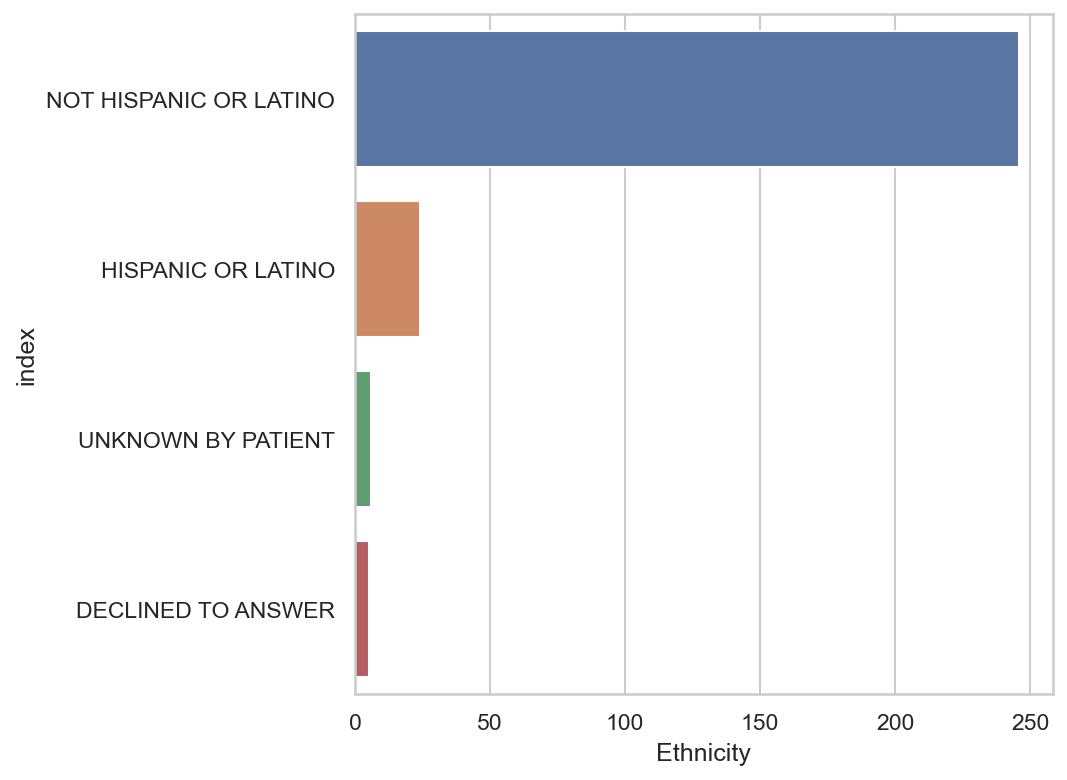

In [106]:
demog = tables['Demorgraphics']

eth_counts = demog.Ethnicity.value_counts().reset_index()
sns.barplot(y='index',x='Ethnicity',data=eth_counts)


<AxesSubplot:xlabel='Race', ylabel='index'>

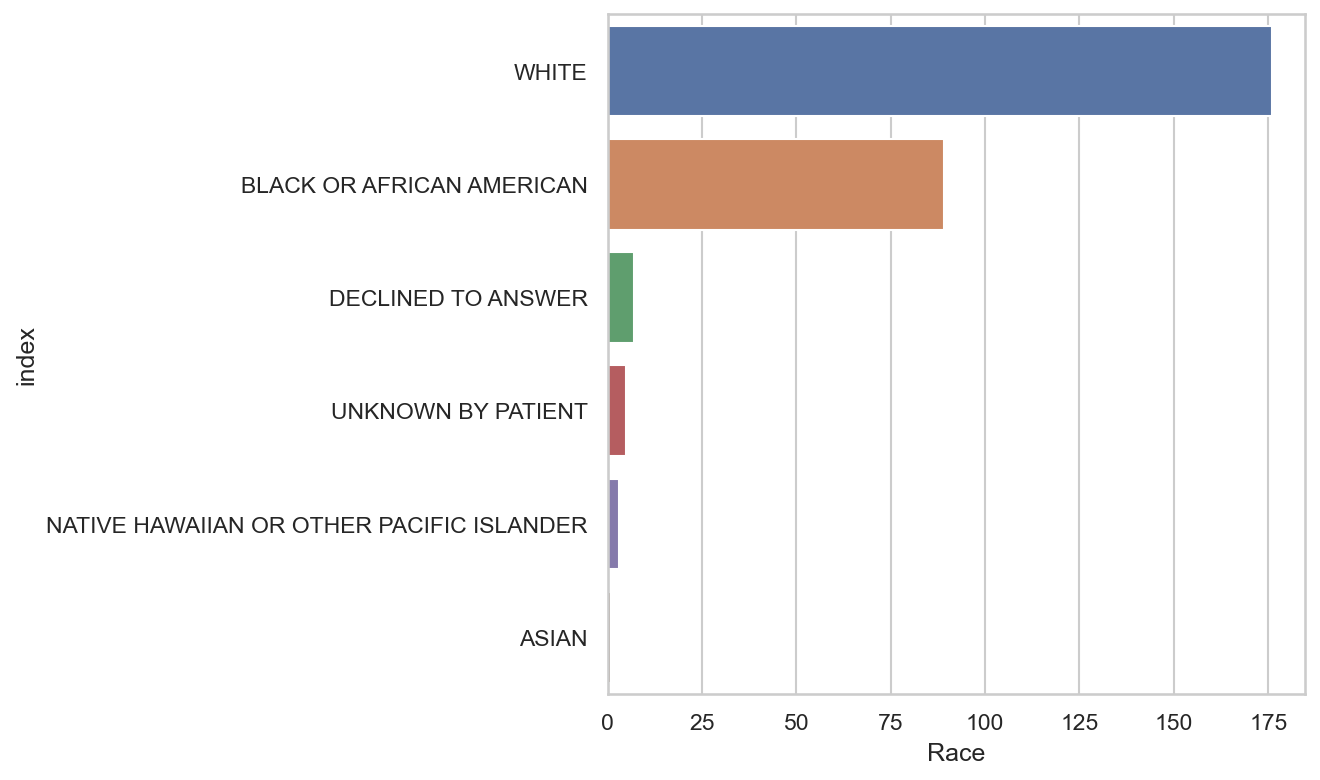

In [105]:
race_counts = demog.Race.value_counts().reset_index()
sns.barplot(y='index',x='Race',data=race_counts)

<AxesSubplot:xlabel='Gender', ylabel='index'>

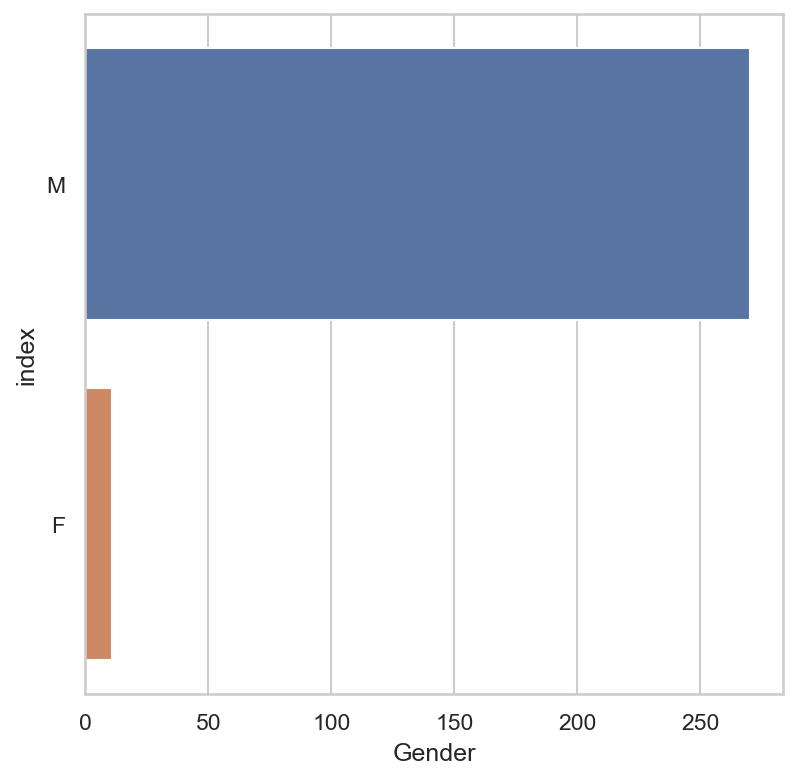

In [108]:
gender_counts = demog.Gender.value_counts().reset_index()
sns.barplot(y='index',x='Gender',data=gender_counts)

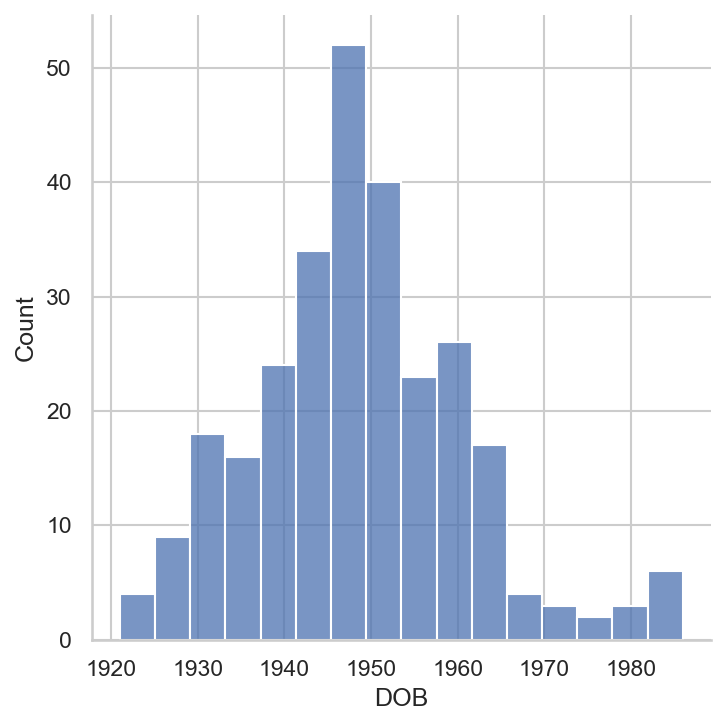

In [114]:
demog.DOB = pd.to_datetime(demog.DOB)
sns.displot(x=demog.DOB.dt.year)

# Assemble demographics DF

In [ ]:
demog[['patientSSN','DOB','Race','Ethnicity','Gender']]


# Discharge diagnosis at index ED visit
- index ED visit is in cohort table
- ICDs are in ICD table
- find the ICDs associated with that index visit discharge

In [ ]:
cohort = tables['cohort'].copy()
ICDs = tables['ICD'].copy()
print(cohort.columns)
print(ICDs.columns)

# convert date time fields to pandas format
datefields = ['EDStartDateTime', 'EDEndDateTime','AdmitDateTime', 'DischargeDateTime']
for datef in datefields:
    cohort[datef] = pd.to_datetime(cohort[datef]) 
ICDs.DiagDateTime = pd.to_datetime(ICDs.DiagDateTime)

# find index visit for each patient
cohort['time_to_admit_days'] = (cohort.AdmitDateTime - cohort.EDEndDateTime).dt.days
index_visit_df = pd.DataFrame(columns=['patientSSN','EDStartDateTime','EDEndDateTime','AdmitDateTime','DischargeDateTime'])
c = 0
for pid in set(cohort.patientSSN):
    rec = cohort[cohort.patientSSN==pid].sort_values(by='AdmitDateTime')
    if rec.shape[0] == 1: # easy case
        index_visit_df.loc[c] = [pid,rec.iloc[0]['EDStartDateTime'],
                                 rec.iloc[0]['EDEndDateTime'],rec.iloc[0]['AdmitDateTime'],
                                 rec.iloc[0]['DischargeDateTime']]
        c = c+1
    if rec.shape[0] == 2: 
        if rec.iloc[0]['EDStartDateTime'] == rec.iloc[1]['EDStartDateTime']: # escalation of care scenario
            ttime = (rec.iloc[1]['AdmitDateTime'] - rec.iloc[0]['DischargeDateTime'])/np.timedelta64(1,'h')
            if ttime < 1:
                index_visit_df.loc[c] = [pid,rec.iloc[0]['EDStartDateTime'],
                                 rec.iloc[0]['EDEndDateTime'],rec.iloc[0]['AdmitDateTime'],
                                 rec.iloc[1]['DischargeDateTime']]
                c = c+1
        else: # different ED visits lead to same hospitalization
            if rec.iloc[0]['AdmitDateTime'] == rec.iloc[1]['AdmitDateTime']:
                # pick the earlier one
                 rec = cohort[cohort.patientSSN==pid].sort_values(by='EDStartDateTime')
                 index_visit_df.loc[c] = [pid,rec.iloc[0]['EDStartDateTime'],
                                 rec.iloc[0]['EDEndDateTime'],rec.iloc[0]['AdmitDateTime'],
                                 rec.iloc[0]['DischargeDateTime']]
                 c = c+1
            else: # different ED visits lead to different hospitalizations
                #display(rec[['EDStartDateTime','AdmitDateTime','DischargeDateTime','time_to_admit_days']])
                index_visit_df.loc[c] = [pid,rec.iloc[0]['EDStartDateTime'],
                                 rec.iloc[0]['EDEndDateTime'],rec.iloc[0]['AdmitDateTime'],
                                 rec.iloc[0]['DischargeDateTime']]
                c = c+1
                index_visit_df.loc[c] = [pid,rec.iloc[1]['EDStartDateTime'],
                                 rec.iloc[1]['EDEndDateTime'],rec.iloc[1]['AdmitDateTime'],
                                 rec.iloc[1]['DischargeDateTime']]
                c = c+1
    if rec.shape[0] > 2:
       print(pid, ' has more than two encounters') 
       display(rec[['EDStartDateTime','AdmitDateTime','DischargeDateTime','time_to_admit_days']])

In [ ]:
index_visit_df

# Exploratory analysis (cohort table)
- identify index ED visit
- identify admit date

In [ ]:
cohort = tables['cohort'].copy()
print(cohort.columns)
datefields = ['EDStartDateTime', 'EDEndDateTime','AdmitDateTime', 'DischargeDateTime']
for datef in datefields:
    cohort[datef] = pd.to_datetime(cohort[datef]) 
cohort['time_in_ED_hrs'] =   (cohort.EDEndDateTime - cohort.EDStartDateTime).dt.seconds/3600
cohort['time_to_admit_days'] = (cohort.AdmitDateTime - cohort.EDEndDateTime).dt.days
# in the 2016-2017 timeframe, when is the index ED visit
for pid in set(cohort.patientSSN):
    rec = cohort[cohort.patientSSN==pid]
    display(rec.sort_values(by='EDStartDateTime')[['patientSSN','EDStartDateTime','EDEndDateTime',
                                                   'AdmitDateTime','DischargeDateTime','time_in_ED_hrs','time_to_admit_days']])

# Exploratory data analysis (consult table)
- who gets neuro consults in the ER?

In [ ]:
consult=tables['Consult'].copy()
print(consult.columns)
consult.RequestDateTime = pd.to_datetime(consult.RequestDateTime)
for pid in set(consult.PatientSSN):
    c = consult[(consult.PatientSSN==pid)&(consult.ConStopCodeName.str.contains("NEURO"))].sort_values(by='RequestDateTime')
    if c.shape[0] > 0:
        print(pid)
        display(c)

In [89]:
print(consult.ConStopCodeName.dropna()[consult.ConStopCodeName.dropna().str.contains("NEURO")].value_counts())
consult.ToRequestServiceName.dropna()[consult.ToRequestServiceName.dropna().str.contains("NEURO")].value_counts()

NEUROLOGY              609
TELEPHONE/NEUROLOGY     96
NEUROSURGERY            75
Name: ConStopCodeName, dtype: int64


NEUROLOGY OUTPATIENT                    82
NEUROLOGY OUTPT                         80
NEUROLOGY INPATIENT                     67
NEUROLOGY INPT                          65
NEUROLOGY OUTPT (SEA)                   55
                                        ..
MED NEURO EMG/NCVS/EVP OUTPT             1
NEUROLOGY CLIN REV INPT CONSULT (F)      1
CHOICE-FIRST NEUROLOGY/NEURO SURGERY     1
FEE BASIS/NEUROLOGY                      1
NEUROLOGY INPT - BT                      1
Name: ToRequestServiceName, Length: 227, dtype: int64

# Exploratory data analysis
- why does a patient come into the ER?
- how long do they spend in the ER visit?

In [ ]:
tmp_reason = cohort.EDVisitReason.str.lower().value_counts()
tmp_reason[tmp_reason >= 3].plot(kind='barh')

In [ ]:
# clean up EDVisitReason column:
# merge dizzy, dizziness
# merge headache, headaches
sdict = {'headache':'headache','dizziness':'dizziness','neuro':'neuro','ha':'headache','dizzy':'dizziness','migraine':'migraine',
        'fall':'fall','headaches':'headache','near syncope':'near syncope','abnormal ekg':'abnormal ekg'}

cohort_visitreason_clean = cohort.EDVisitReason.apply(lambda x: sdict[x] if x in sdict else x)
tmp_reason_clean[tmp_reaso]
#tmp_reason_clean[tmp_reason_clean >=3].plot(kind='barh')

In [ ]:
sdict['ha']

In [ ]:
cohort.EDStartDateTime = pd.to_datetime(cohort.EDStartDateTime)
cohort.EDEndDateTime = pd.to_datetime(cohort.EDEndDateTime)
tmp_EDtime = (cohort.EDEndDateTime - cohort.EDStartDateTime)
time_in_ED = tmp.dt.seconds/3600
time_in_ED.hist(bins=30)
time_in_ED.describe()